# Bond Pricing

* maturity (T)
    - date
* coupon
    - type
    - rate
    - frequency
* bid/ask prices
    - clean vs. dirty
    - accrued interest
* yield (r)

bid/ask prices usually are quoted as percentage of par value at a clean price.

\begin{equation}
\text{Bond value}=\sum_{t=1}^{T}\frac{\text{Coupon}}{(1+r)^t}+\frac{\text{Par Value}}{(1+r)^T}
\end{equation}

If the coupons and r are fixed:

\begin{equation}
\text{Bond value}=\frac{\text{Coupon}}{r}\times(1-(1+r)^{-T})+\text{Par Value}\times(1+r)^{-T}
\end{equation}

## Accrued Interest and Quoted Prices

If you buy a bond x days after its issuance you must pay the accrued interest to the seller as follow:

$$\text{Dirty Price}=\text{Clean Price}+\text{Accrued interest}$$

where:

$$\text{Accrued Interest}=\frac{\text{Annual coupon payment}}{\text{coupon pmt p.a.}}\times\frac{\text{days since last pmt}}{\text{days between pmts}}$$

If you don't know the clean price:

1. $T = \text{maturity date}-\text{last coupon date}$;
2.  Calculate the FV from the last coupon date to the date you are interest in.

*this price will be the dirty price*



## Yield to Maturity (YtM)
YtM is the IRR of the bond - the interest rate that makes the PV of a bond's payments equal to its price.
It's the average rate of return that would be earned on a bond held until maturity, if all coupons are reinvested at the same interest rate.

**The relationship between Yield and Bond Price is negative as follows**


$$\uparrow\text{YtM}\Longleftrightarrow\downarrow\text{Bond price}$$


In [86]:
def quoted_bond_price(maturity, yield_, coupon):
    """Prices a bond as percentage of par value."""
    annuity_factor = (1/yield_)*(1-(1+yield_)**(-maturity))
    pv_factor = (1+yield_)**(-maturity)
    return coupon*annuity_factor + pv_factor

In [14]:
def bond_prices_vs_yield(maturity, coupon, yield_i, yield_f):
    """Plots the relationship between bond price and yields."""
    import numpy as np
    import pandas as pd
    import seaborn as sns
    yields = np.arange(yield_i, yield_f, step=0.01)
    prices = [quoted_bond_price(maturity, x, coupon) for x in yields]
    bond_df = pd.DataFrame({'Yield': yields, 'Price': prices})   
    return sns.lineplot(x=bond_df.Yield, y=bond_df.Price)

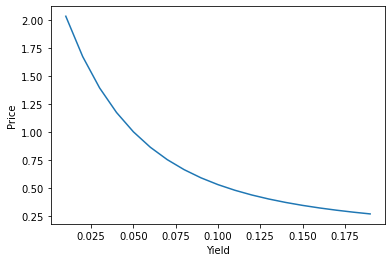

In [15]:
bond_prices_vs_yield(30, 0.05, 0.01, 0.2)


**The yield-to-Bond price relationship derived above is sensitive to the maturity. Long-term bond's price vary more than short-term bond's price as follows**

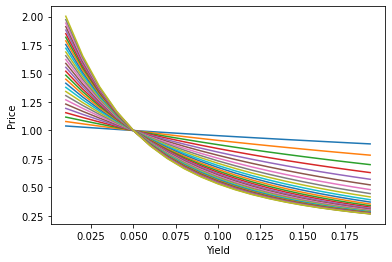

In [66]:
import numpy as np
for i in np.arange(1, 30):
    bond_prices_vs_yield(i, 0.05, 0.01, 0.2)

# Interest Rate Sensivity
* **Yield curve**: is a plot of YtM as function of maturities

1. *Bond prices* and *yields* are *inversely related*: as yields increase, bond prices fall; as yields fall, bond prices rise
2. An *increase in a bond’s yield to maturity* results in a *smaller price change* than a *decrease in yield* of equal magnitude
3. *Prices of long-term bonds* tend to be *more sensitive* to *interest rate changes* than prices of short-term bonds
4. The *sensitivity of bond prices to changes in yields increases at a decreasing rate as maturity increases*. In other words, interest rate risk is less than proportional to bond maturity.
5. *Interest rate risk is inversely related to the bond’s coupon rate*. Prices of low-coupon bonds are more sensitive to changes in interest rates than prices of high-coupon bonds.
6. The *sensitivity of a bond’s price to a change in its yield is inversely related to the yield to maturity at which the bond currently is selling*

## Macaulay duration
Measures the "real" maturity of a bond. It serves as a guide to the sensitivity of a bond to interest rate.

$$D=\frac{\sum_{t=1}^{T}t\times\frac{CF_t}{(1+YtM)^t}}{\text{Bond Price}}$$

### Modified duration
\begin{array}
\text{MD}&=\frac{D}{(1+YtM)}\\
\frac{\Delta P}{P}&=-MD\times\Delta YtM\\
\end{array}

* The duration of a zero-coupon bond is equal its maturity
* Duration is lower when the coupon is higher
* Duration is higher when YtM is lower
* Practitioners use BPV (or PV01): price change in \% or \$ for one base point.

$$PV01=MD\times Price\times 0.01\%$$

## wrapping up
- $\uparrow\text{YtM}\Longleftrightarrow\downarrow\text{Bond price}$
- $\uparrow\text{MD}\Longleftrightarrow\downarrow\text{YtM}$
- $\uparrow\text{MD}\Longleftrightarrow\downarrow\text{coupon}$
- $\uparrow\text{MD}\Longleftrightarrow\uparrow\text{maturity}$
- $\downarrow\Delta\text{MD}\Longleftrightarrow\uparrow\text{maturity}$

In [47]:
def bond_cash_flows(maturity, coupon_rate, coupons_per_year=1):
    """Returns a series of cash flows generated by a bond."""
    import numpy as np
    import pandas as pd
    n_coupons = round(maturity*coupons_per_year)
    coupon_pmt = (coupon_rate/coupons_per_year)
    coupon_index = np.arange(1, n_coupons + 1)
    cash_flows = pd.Series(data = coupon_pmt, index = coupon_index)
    cash_flows.iloc[-1] += 1
    return pd.Series(cash_flows)

def discount(t, r):
    """Returns a discounted rates series."""
    import pandas as pd
    discounts = pd.Series([(r+1)**-i for i in t])
    discounts.index = t
    return discounts

def pv(flows, r):
    """Computes the pv of cash flows indexed by time."""
    dates = flows.index
    discounts = discount(dates, r)
    return discounts.multiply(flows, axis='rows').sum()

def bond_price(maturity, coupon_rate, coupons_per_year, discount_rate):
    """Prices a bond based on its cash flows."""
    import pandas as pd
    if maturity <= 0:
        return (1 + coupon_rate/coupons_per_year)
    else:
        cash_flows = bond_cash_flows(maturity,
                                     coupon_rate, coupons_per_year)
        return pv(cash_flows, discount_rate/coupons_per_year)

def macauly_duration(cash_flows, discount_rate):
    """Computes the Macauly duration of a bond."""
    import numpy as np
    import pandas as pd
    discounted_flows = discount(cash_flows.index, discount_rate)*cash_flows
    weights = discounted_flows/discounted_flows.sum()
    return np.average(pd.Series(cash_flows.index), weights=weights)

def modified_duration(macauly_duration, ytm, maturity):
    """Computes the modified duration of a bond."""
    return macauly_duration/(1 + ytm/maturity)

In [60]:
def md_vs_maturity(maturity_i, maturity_f, coupon_rate, ytm):
    import numpy as np
    import pandas as pd
    import seaborn as sns
    maturities = np.arange(maturity_i, maturity_f, step=1)
    mds = []
    for maturity in maturities:
        cf = bond_cash_flows(maturity, coupon_rate=coupon_rate, coupons_per_year=1)
        mds.append(modified_duration(macauly_duration(cf, ytm), ytm, maturity))
    bond_df = pd.DataFrame({'MD': mds, 'Maturity': maturities})
    return sns.lineplot(x=bond_df.Maturity, y=bond_df.MD)

**MD (sensibility) increases as Maturity increases** 

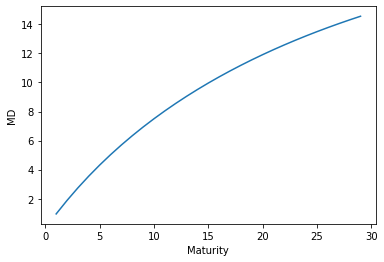

In [62]:
md_vs_maturity(1, 30, 0.08, 0.05)

**MD (sensibility) increases as YtM decreases** 

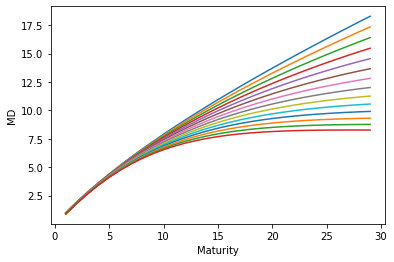

In [68]:
import numpy as np
for i in np.arange(0.01, 0.15, step=0.01):
    md_vs_maturity(1, 30, 0.08, i)

## Convexity
As the relationship between bond prices and yields are not linear, the duration rule is good approximation just for small changes in bond yield. Convexity allows improvement on duration aproximation for bond price changes.
\begin{array}
\text{Convexity}&=\frac{1}{P\times(1+YtM)^2}\times\sum_{t=1}^{T}\big(\frac{CF_t}{(1+YtM)^t}\times(t^2+t)\big)\\
\frac{\Delta P}{P}&=-MD\times\Delta YtM+\frac{\text{Convexity}\times\Delta YtM^2}{2}\\
\end{array}

In [72]:
# A bond with 10y maturity, sensitivity 8, yield 4% is priced at 98% what is the coupon?
# if coupon = yield -> price = 1 -> deltaytm = delta p/MD -> coupon - ytm = delta p/md
md = 8
delta_p = 0.98 - 1
ytm = 0.04
coupon = ytm + delta_p/md
coupon

0.0375

In [79]:
# A bond is quoted at 110%, its md is 5. supposing the yield goes down by 10 basis points. What would be its price?
md = 5
p = 1.10
delta_y = -0.001
-(delta_y*md - p)

1.105

In [85]:
# A 10y bond, coupon 2% and md equal to 8.978 and yield 1.95%
# Price?
# md = delta price/delta yield -> md*(0.02 - 0.0195)=(p - 1)
md = 8.978
delta_y = 0.02 - 0.0195
p = md*delta_y + 1
p

1.004489

In [91]:
# 210 days later the bond trades with a yield of 2.5%. What are the clean and dirty price?
dp = quoted_bond_price(10, 0.025, 0.02)*(1+0.025)**(210/365)
ai = 0.02*(210/365)
cp = dp - ai
print('clean Price: ', cp, '; dirty Price: ', dp)

clean Price:  0.9584148073395676 ; dirty Price:  0.9699216566546361


In [92]:
# P&L (10M)
(dp - p)*10

-0.3456734334536382

# Hedging with duration
$$\text{Hedging ratio}=\frac{P_1\times MD_1}{P_2\times MD_2}$$
or:
$$HR=-BPV_1/BPV_2$$

1. 10M 3%10y, YtM 2,5% - quoted 104.376%, MD=8,6
2. x? 2.5%7y, YtM 1.75% - quoted 104.901%, MD=6.41

To hedge 10M of 1 you need to sell 13.349M of the 2.

In [97]:
hr = (1.04376*8.6)/(1.04901*6.41)
hr*10

13.349390669080591

# Floating Rate Notes (FRN)
- variable coupon
- Discount Margin (cristalization)
    1. last known reference
    2. yield for a given price
    3. Discount Margin = yield - Reference
    
5y bond paying Euribor + 1% coupons
    - last euribor = 2%
    - price 102%
    - MD = 4.61
    
       cristalized coupon = 2% + 1%  

In [105]:
# delta p/p = -md * deltaY
coupon = 0.03
md = 4.61
p =1.02
delta_p = 1 - p
delta_y = -(delta_p/(p*md))
y = 0.03 - delta_y
y - 0.02

0.005746671770660537